In [14]:
%load_ext autoreload
%autoreload 2

import plot
import shear
import util
import telemetry
import fitsio

import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import desietc.gmm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
path = "/global/cfs/cdirs/desi/spectro/ETC/20210413/00084648/gfaetc_00084648.fits"
os.path.exists(path)

True

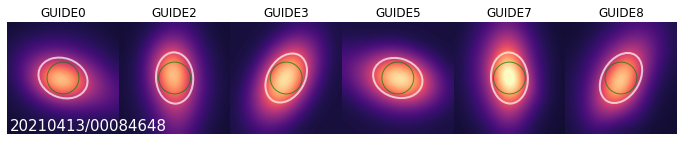

In [16]:
d = util.read_fits(path)
night = d["expinfo"]['night']
expid = d['expinfo']['expid']
mjd = d['expinfo']['MJD']
shear_data = shear.shear_matrix(night, expid, mjd, d)
plot.plot(d, shear_data)

In [17]:
shear_data['GUIDE7']

{'night': 20210413,
 'expid': 84648,
 'mjd': 59318.36255899,
 'Q': array([[17.1127799 , -0.94866984],
        [-0.94866984, 32.69118278]]),
 'a': 5.722651550766637,
 'b': 4.12979683597627,
 'beta': 1.63139435192802,
 'q': 0.7216579236635543,
 's': 4.861418339101332,
 'e1': -0.16048505463156093,
 'e2': -0.01954594870115499,
 'g1': -0.16048505463156099,
 'g2': -0.019545948701155}

In [29]:
psf = d['GUIDE']['GUIDE7']['model']
Q = get_Q(psf)

# Read in gmm_params

In [44]:
psf_pixels = 25
psf_grid = np.arange(psf_pixels + 1) - psf_pixels / 2
GMM = desietc.gmm.GMMFit(psf_grid, psf_grid)

camera = "GUIDE7"
with fitsio.FITS(path, mode="r") as hdus:
    params = fitsio.read(path, ext=camera+"M")
    
bgdensity = params[0]
gmm_params = params[1:].reshape(3, -1)

# Split them into 3 separate Gaussians

[[ 0.10394826  1.0968055  -0.6386829   3.1675904   3.0862763  -0.36770687]
 [ 0.82077914 -1.1561128   1.8730706   5.113481    8.0493355  -0.00962053]
 [ 0.4656792  -0.27715263  0.09465953  2.7111583   6.2249975  -0.04077446]]


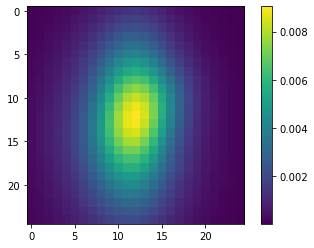

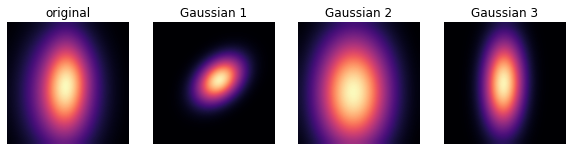

In [70]:
p1 = np.zeros(len(gmm_params[0])+1)
p1[0] = bgdensity
p1[1:] = gmm_params[0]

p2 = np.zeros(len(gmm_params[0])+1)
p2[0] = bgdensity
p2[1:] = gmm_params[1]

p3 = np.zeros(len(gmm_params[0])+1)
p3[0] = bgdensity
p3[1:] = gmm_params[2]

psf1 = GMM.predict(p1)
psf2 = GMM.predict(p2)
psf3 = GMM.predict(p3)

psf = gmm_params[0, 0] * psf1 + gmm_params[1, 0] * psf2 + gmm_params[2, 0] * psf3 # gmm_params[i, 0] is each weight
psf *= bgdensity
psf_k = GMM.predict(params)
plt.imshow(psf_k - psf)
plt.colorbar()
print(gmm_params)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))
for i, psf in enumerate([psf, psf1, psf2, psf3]):
    axs[i].imshow(psf, cmap=plt.cm.magma, interpolation='bicubic')
    axs[i].axis('off')
    title = "original" if i == 0 else "Gaussian " + str(i) 
    axs[i].set_title(title)

In [83]:
(psf < 0).sum()

0

In [71]:
def get_Q(psf):
    Q = np.zeros((2, 2))
    
    center = psf.shape[0] / 2
    y, x = np.indices((psf.shape))
    
    denom = np.sum(psf)
 
    rx = (x - center)
    ry = (y - center)
    rxy = (x - center) * (y - center)

    mux = np.sum(rx * psf) / denom
    muy = np.sum(ry * psf) / denom

    rx -= mux
    ry -= muy

    Q[0, 0] = np.sum(rx ** 2 * psf) / denom
    Q[1, 1] = np.sum(ry ** 2 * psf) / denom
    Q[0, 1] = np.sum(rx * ry * psf) / denom
    Q[1, 0] = Q[0, 1]
    
    return Q

Q_original = get_Q(psf)
Q1 = get_Q(psf1)
Q2 = get_Q(psf2)
Q3 = get_Q(psf3)
Q_k = get_Q(psf_k)

Q_list = [Q_original, Q1, Q2, Q3]

In [72]:
def get_a2b2(Q):
    """ Computes a^2 and b^2 from Q
    """
    Q11 = Q[0, 0]
    Q22 = Q[1, 1]
    Q12 = Q[0, 1]
    Q1122 = Q11 + Q22
    disc = np.sqrt((Q11 - Q22) ** 2 + 4 * Q12 ** 2)
    
    a2t = 0.5 * (Q1122 + disc)
    b2t = 0.5 * (Q1122 - disc)
    a2, b2 = max(a2t, b2t), min(a2t, b2t)
    assert a2 >= b2

    return a2, b2

def get_beta(Q):
    """Computes beta from Q
    """
    import math
    U, s, _ = np.linalg.svd(Q)
    beta = np.arctan2(U[1, 0], U[0, 0])
    Q12 = Q[0, 1]
    Q11 = Q[0, 0]
    Q22 = Q[1, 1]
    #beta = 0.5 * np.arcsin(2 * Q12 / (a2 - b2))
    #beta = 0.5 * np.arctan(2 * Q12 / (Q11 - Q22))
    return beta

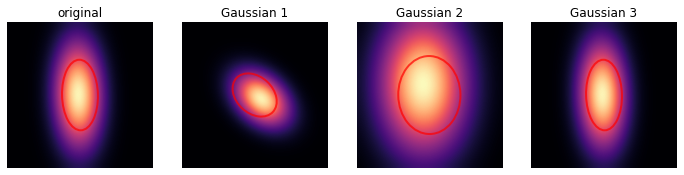

In [73]:
def draw_ellipse_se1e2(ax, x0, y0, s, g1, g2, nsigmas=1.1, **ellipseopts):
    g = np.sqrt(g1 ** 2 + g2 ** 2)
    if g > 1:
        raise ValueError('g1 ** 2 + g2 ** 2 > 1')
    center = np.array([x0, y0])
    angle = np.rad2deg(0.5 * np.arctan2(g2, g1))
    ratio = np.sqrt((1 + g) / (1 - g))
    width = 2 * s * ratio * nsigmas
    height  = 2 * s / ratio * nsigmas
    kwargs = dict(color='r', ls='-', lw=2, alpha=0.7, fill=False)
    kwargs.update(ellipseopts)
    ellipse = matplotlib.patches.Ellipse(center, width, height, angle, **kwargs)
    ax.add_artist(ellipse)
    

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 10))
for i, psf in enumerate([psf, psf1, psf2, psf3]):
    axs[i].imshow(psf, origin='lower', extent=2*[-psf.shape[0]/2,psf.shape[0]/2], cmap=plt.cm.magma, interpolation='bicubic')
    axs[i].axis('off')
    title = "original" if i == 0 else "Gaussian " + str(i) 
    axs[i].set_title(title)
    
    Q = Q_list[i]
    a2, b2 = get_a2b2(Q)
    a, b, = np.sqrt(a2), np.sqrt(b2)
    beta = get_beta(Q)
    
    g = (a - b) / (a + b)
    g1 = g * np.cos(2 * beta)
    g2 = g * np.sin(2 * beta)
    s = np.linalg.det(Q) ** (1/4)
    draw_ellipse_se1e2(axs[i], 0, 0, s, g1, g2)

In [74]:
for i, Q in enumerate(Q_list):
    a2, b2 = get_a2b2(Q)
    a, b = np.sqrt(a2), np.sqrt(b2)
    beta = get_beta(Q)
    beta = np.rad2deg(beta)
    print("a = {a:.5f}, b = {b:.5f}".format(a=a, b=b))
    print("ratio = {:.5f}".format(a/b))
    print("beta = {:.5f}".format(beta))
    print()

a = 5.51098, b = 2.80410
ratio = 1.96533
beta = 91.34691

a = 3.88433, b = 2.85413
ratio = 1.36095
beta = 137.09738

a = 6.08951, b = 4.85533
ratio = 1.25419
beta = 90.87812

a = 5.51098, b = 2.80410
ratio = 1.96533
beta = 91.34691



In [75]:
get_a2b2(Q_k)

(32.74874077149179, 17.055221906439613)

In [76]:
get_a2b2(Q_original)

(30.37095420938097, 7.862960964040411)